In [1]:
import torch
import joblib
import pandas
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

# 데이터셋 분할

In [2]:
dataset = joblib.load('DataFrame/agv_dataframe.pkl')
X,y = dataset.drop(columns='state'),dataset['state']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=False)
# X_test,y_test = X_test.reset_index(drop=True),y_test.reset_index(drop=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
y_train.value_counts(normalize=True)

(28298, 12) (12129, 12) (28298,) (12129,)


state
0    0.516609
2    0.207400
1    0.206022
3    0.069970
Name: proportion, dtype: float64

# 파이토치 멀티 모달 데이터셋 

In [3]:
class MultimodalDataset(Dataset):
    """사용자 정의 멀티모달 데이터셋"""
    def __init__(self,X:pandas.DataFrame,y:pandas.Series):
        """필요한 데이터를 이곳에서 선언
        Parameter:
        X: 열화상 이미지와 센서데이터의 데이터 프레임
        y: 정답 데이터의
        """
        self.X = X
        self.y = y
    def __getitem__(self, index):
        """열화상 이미지 [1,120,160]크기와 센서 데이터 11개의 칼럼 그리고 이에 해당하는 정답 데이터 반환"""
        image = torch.tensor(np.load(self.X.iloc[index]['filenames']),dtype=torch.float32).unsqueeze(0)
        sensor_features = self.X.drop(columns=['filenames'])
        sensor_features = torch.tensor(sensor_features.iloc[index].values,dtype=torch.float32)
        label = int(self.y.iloc[index]) # 나중에 학습하는데 있어서 느려지게하는 요인이면 데이터 프레임 자체에서 변경함함
        return image, sensor_features, label
    
    def __len__(self):
        return len(self.X)

train_dataset = MultimodalDataset(X_train,y_train)
test_dataset = MultimodalDataset(X_test,y_test)

train_image,train_sensor_features,train_label = train_dataset[0]
test_image,test_sensor_features,test_label = test_dataset[0]

print(len(train_dataset))
print(train_image.shape,train_sensor_features.shape,train_label)

print(len(test_dataset))
print(test_image.shape,test_sensor_features.shape,test_label)

28298
torch.Size([1, 120, 160]) torch.Size([11]) 0
12129
torch.Size([1, 120, 160]) torch.Size([11]) 0


# 멀티 모달 데이터 로더

In [4]:
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=False)
print(len(train_dataloader),len(test_dataloader))

1769 759


# 멀티모달 AI 모델

In [5]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        # Transformer 설정
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        # Patch embedding: 채널을 1로 설정
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        # 포지셔널 임베딩
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        # x: [batch_size, 1, img_dim_h, img_dim_w]
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding  # Positional embedding 추가
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]

class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        return attn_output

class ConditionClassifier(nn.Module):
    def __init__(self, img_dim_h,img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim)
        self.cross_attention = CrossAttention(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        # Feature extraction
        visual_features = self.vit(images)  # [batch_size, embed_dim]
        aux_features = self.soft_label_encoder(aux_data)  # [batch_size, embed_dim]

        # Cross attention
        visual_features = visual_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        aux_features = aux_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        integrated_features = self.cross_attention(visual_features, aux_features).squeeze(1)

        # Classification
        output = self.classifier(integrated_features)  # [batch_size, num_classes]
        return output
    
img_dim_h = 120  # 열화상 이미지 세로 크기
img_dim_w = 160  # 열화상 이미지 가로 크기
patch_size = 16
embed_dim = 128
num_heads = 4
depth = 6
aux_input_dim = 11  # 보조 데이터 차원 (예: 온도, 습도 등)
num_classes = 4  # 0:정상,1:관심,2:주의,3:위험
model = ConditionClassifier(img_dim_w, img_dim_h, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes)

# 학습 및 평가 파이프라인

In [6]:
from tqdm.auto import tqdm
def train_step(model:torch.nn.Module,
               train_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device:torch.device='cuda'):
    model.train()
    # 모델도 GPU 환경으로 보내기 (모델 학습시 GPU 학습 가속화)
    model = model.to(device)
    train_loss, train_acc = 0.0, 0.0
    for batch_images,batch_features,target in tqdm(train_loader):
        # GPU 상으로 데이터 보내기 (모델 학습시 GPU 학습 가속화)
        batch_images,batch_features,target = batch_images.to(device),batch_features.to(device),target.to(device)
        # 데이터 -> 모델 입력 
        y_pred = model(batch_images,batch_features)
        # 로스값 계산
        loss = loss_fn(y_pred,target)
        train_loss += loss.item()
        # 최적화 기울기 초기화
        optimizer.zero_grad()
        # 역전파 Loss Backward
        loss.backward()
        # Optimizer Step 가중치 업데이트
        optimizer.step()
        # 정확도 계산
        y_pred_class = torch.argmax(F.softmax(y_pred,dim=1),dim=1)
        train_acc += ((y_pred_class==target).sum().item()/len(y_pred))
    train_loss,train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
    return train_loss,train_acc

def test_step(model:torch.nn.Module,
              test_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device='cuda'):
    # 평가 모드
    model.eval()
    test_loss,test_acc = 0.0, 0.0
    # 추론 모드
    with torch.inference_mode():
        for batch_images,batch_features,target in tqdm(test_loader):
            # GPU 상으로 데이터 보내기 (모델 학습시 GPU 학습 가속화)
            batch_images,batch_features,target = batch_images.to(device),batch_features.to(device),target.to(device)
            
            # 데이터 -> 모델 입력 
            test_pred_logits = model(batch_images,batch_features)
            
            # 로스 계산
            loss = loss_fn(test_pred_logits,target)
            test_loss += loss.item()
            
            # 정확도 계산
            test_pred_class = torch.argmax(F.softmax(test_pred_logits,dim=1),dim=1)
            test_acc += ((test_pred_class==target).sum().item()/len(test_pred_logits))
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_loader)        
    return test_loss,test_acc

c:\Users\hyssk\anaconda3\envs\pytorch_cuda_11_8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 데이터 불균형으로 인해 Focal Loss & CrossEntropyLoss 비교

In [7]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
# loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=0.0001)

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce_loss(logits, targets)
        pt = torch.exp(-ce_loss)  # 예측 확률
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

# train_dataloader = iter(train_dataloader)
# images,features,targets =next(train_dataloader)
# # 사용 예시
focal_loss = FocalLoss(alpha=0.25, gamma=2) # Focal Loss 파라미터 초기화
# logits = model(images,features) # 로짓 (모델에서 나온 값을 보통 로짓이라고 부름)
# loss = focal_loss(logits, targets) # 포칼로스
# loss_ce = loss_fn(logits,targets) # 크로스엔트로피 로스

# print("Focal Loss:", loss.item()) # 검출하기 쉬운 0(정상) 상태인거는 낮은 Loss값을
# print("CrossEntropyLoss:",loss_ce.item()) # CrossEntropy는 더 검출하기 쉽거나 그러한 개념이 없기 때문에 쉽게 검출 할 수 있는 것도 Focal Loss보다 로스값을 가짐
# print(logits)
# print(targets)

In [ ]:
EPOCHS = 15
results = {'train_acc':[],'train_loss':[],'test_acc':[],'test_loss':[]}
maximum_test_acc = 0

for epoch in range(1,EPOCHS+1,1):
    print(f"THIS IS {epoch} times")
    train_loss,train_acc = train_step(model,train_dataloader,focal_loss,optimizer)
    results['train_acc'].append(train_acc)
    results['train_loss'].append(train_loss)
    print(f'train_loss:{train_loss} | train_acc:{train_acc}')
    
    test_loss,test_acc = test_step(model,test_dataloader,focal_loss)
    results['test_acc'].append(test_acc)
    results['test_loss'].append(test_loss)
    
    print(f'test_loss:{test_loss} | test_acc:{test_acc}')
    
    if maximum_test_acc < test_acc:
        maximum_test_acc = test_acc
        # torch.save(model,'Best_Model.pth')
        print(f'Best Model was saved. | test_acc : {test_acc}')
    else:
        pass
    
    print('-'*100)

In [ ]:
print(test_dataloader.dataset)

In [9]:
model.state_dict()

OrderedDict([('vit.pos_embedding',
              tensor([[[ 0.1990, -1.5116, -0.8229,  ...,  0.3091,  0.1851,  0.3999],
                       [ 1.0646, -0.6785,  0.6968,  ...,  0.6441, -0.2952, -0.0254],
                       [-1.3201, -0.2835,  0.0940,  ..., -0.2378, -0.4250, -0.6421],
                       ...,
                       [ 0.7240, -0.2048, -0.3700,  ..., -1.7926,  1.3555, -0.6436],
                       [ 1.0154,  0.3893, -0.5016,  ...,  0.0738,  0.4035, -1.9494],
                       [ 0.6421,  1.5845, -0.9510,  ...,  0.2846,  0.3373, -0.1936]]])),
             ('vit.vit.encoder.layers.0.self_attn.in_proj_weight',
              tensor([[ 0.0737,  0.0690, -0.0409,  ...,  0.1040,  0.0910, -0.0534],
                      [ 0.0480,  0.0860, -0.0252,  ..., -0.0047,  0.0242, -0.0224],
                      [-0.0953, -0.0349, -0.1035,  ...,  0.0262,  0.0639, -0.0537],
                      ...,
                      [-0.0931, -0.0791,  0.0889,  ..., -0.0294, -0.0933,  0.

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results['train_acc'],label='train_acc')
plt.plot(results['test_acc'],label='test_acc')
plt.legend()
plt.xlabel('Epochs')
plt.show()

plt.figure()
plt.plot(results['train_loss'],label='train_loss')
plt.plot(results['test_loss'],label='test_loss')
plt.legend()
plt.xlabel('Epochs')
plt.show()

c:\Users\hyssk\anaconda3\envs\pytorch_cuda_11_8\lib\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._transformer_encoder_layer_fwd(


tensor([3., 3., 3.,  ..., 3., 3., 3.], device='cuda:0')
tensor([0., 0., 0.,  ..., 3., 3., 3.], device='cuda:0')


NameError: name 'plt' is not defined

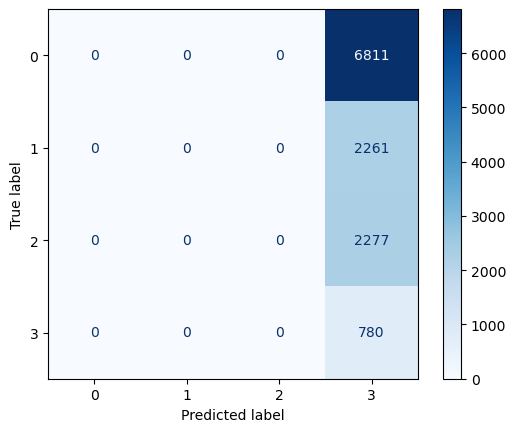

In [11]:
y_true = torch.tensor([]).to(device='cuda')
y_pred = torch.tensor([]).to(device='cuda')

with torch.inference_mode():
    model.eval()
    for images,features,targets in test_dataloader:
        images, features, targets = images.to('cuda'), features.to('cuda'), targets.to('cuda')
        predictions = torch.argmax(F.softmax(model(images,features),dim=1),dim=1)
        y_pred = torch.cat((y_pred, predictions))
        y_true = torch.cat((y_true, targets))
print(y_pred)
print(y_true)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_true = y_true.cpu()
y_pred = y_pred.cpu()
cm = confusion_matrix(y_true,y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()
print(classification_report(y_true,y_pred))

In [ ]:
print(classification_report(y_true,y_pred))